In [1]:
!pip install gymnasium
!pip install gym-notices

In [2]:
import gymnasium as gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)
import copy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda:0" if torch.cuda.is_available() else
                      "cpu")
device = torch.device("cpu")


CartPole-v1


100%|██████████| 10000/10000 [00:35<00:00, 283.77it/s]


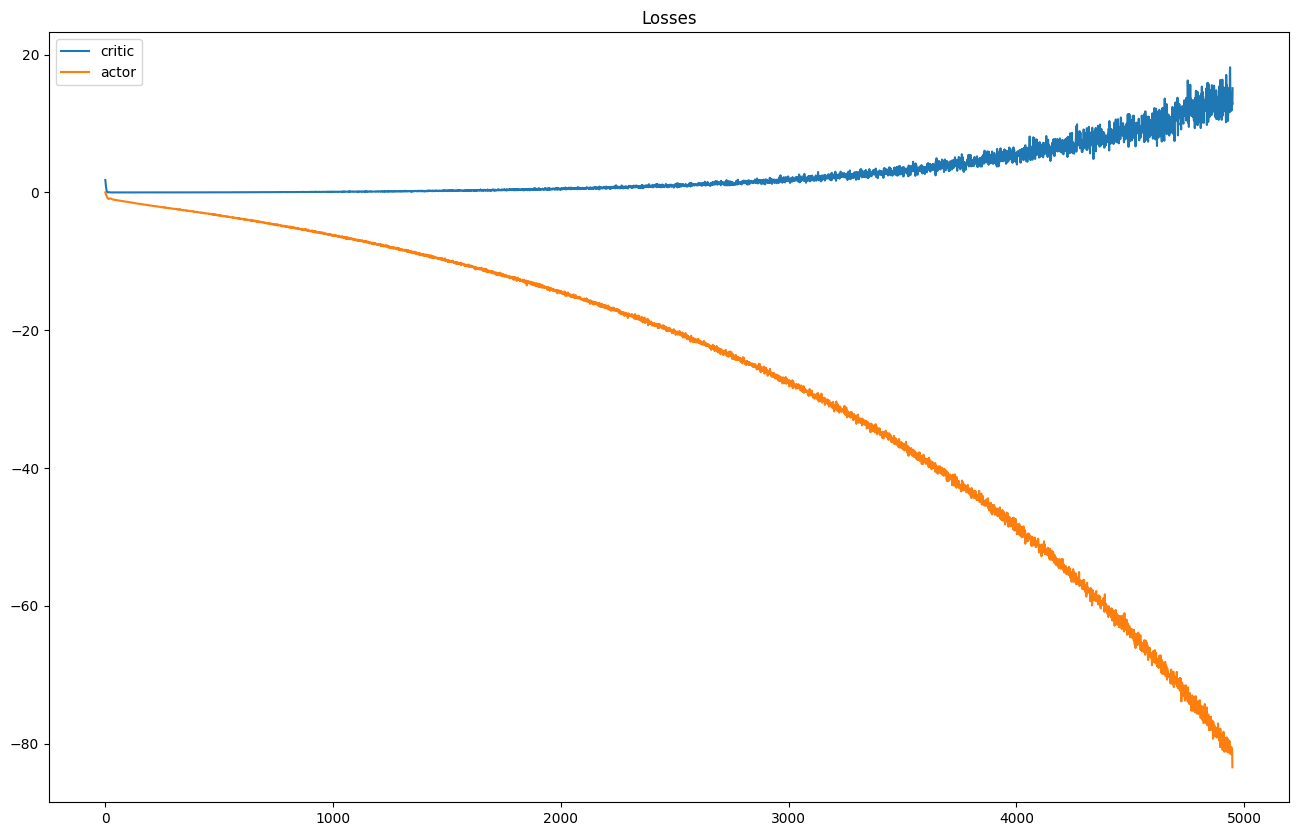

In [3]:
class ReplayBuffer(object):
    # max size ?
    def __init__(self, state_dim, action_dim):
        self.state_buffer = torch.empty((0, state_dim))
        self.action_buffer = torch.empty((0, action_dim))
        self.reward_buffer = torch.empty((0, 1), dtype=torch.float32)
        self.next_state_buffer = torch.empty((0, state_dim))
        self.done_buffer = torch.empty((0, 1), dtype=torch.int)

    def add_entry(self, state, action, reward, next_state, done):
        self.state_buffer = torch.cat(
            (self.state_buffer, torch.from_numpy(state).reshape(1,-1)),dim=0)
        self.action_buffer = torch.cat(
            (self.action_buffer, torch.tensor([action]).reshape(1,-1)), dim=0)
        self.reward_buffer = torch.cat(
            (self.reward_buffer, torch.tensor([reward], dtype=torch.float32).reshape(1,-1)), dim=0)
        self.next_state_buffer = torch.cat(
            (self.next_state_buffer, torch.from_numpy(next_state).reshape(1,-1)), dim=0)
        self.done_buffer = torch.cat(
            (self.done_buffer, torch.tensor([done], dtype=torch.int).reshape(1,-1)), dim=0)
    
    def sample(self, batch_size=1) -> dict:
        indices = torch.randint(0, self.state_buffer.shape[1], size=(batch_size,1)).squeeze()
        batch = (
            self.state_buffer[indices],
            self.action_buffer[indices],
            self.reward_buffer[indices],
            self.next_state_buffer[indices],
            self.done_buffer[indices]
            )
        return batch



class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, hidden_dim=256):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, action_dim)

        self.max_action = max_action

    def forward(self, state):
        probs = F.relu(self.l1(state))
        probs = F.relu(self.l2(probs))
        probs = F.tanh(self.l3(probs))
        return probs*self.max_action


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, action_dim)
        

    def forward(self, state, action):
        state_action = torch.cat([state, action], dim=1)

        q = F.relu(self.l1(state_action))
        q = F.relu(self.l2(q))
        q = self.l3(q)

        return q
    

EXPL_NOISE = 0.1          # standard deviation of exploration noise
TARGET_ACTION_NOISE = 0.2 # standard deviation of noise added to target policy during critic update
NOISE_CLIP = 0.5          # clip target policy noise
BATCH_SIZE = 256          # 256 
DISCOUNT = 0.99           # discount factor
TAU = 0.005               # target network update rate
START_TIME = 1e2         # 25e3 in official implementation
POLICY_UPDATE_PERIOD = 2  # number of steps between delayed policy updates

def train_TD3(env, max_t=int(1e4), n_episodes=1000):    # 1e6 timesteps in official implementation

    # all classical control envs have continuous states
    state_dim = env.observation_space.shape[0]

    # check if action space is discrete
    discrete_actions = isinstance(env.action_space, gym.spaces.Discrete)
    if discrete_actions:
        action_dim = 1
        min_action = 0
        max_action = env.action_space.n - 1

    else:   # continuous action space
        action_dim = env.action_space.shape[0]
        assert env.action_space.low.shape == (1,), 'env has action_dim > 1'
        min_action = env.action_space.low[0]
        max_action = env.action_space.high[0]

    actor = Actor(state_dim, action_dim, max_action).to(device)
    target_actor = copy.deepcopy(actor).to(device)
    actor_optimizer = torch.optim.Adam(actor.parameters(), lr=3e-4)

    critic_1 = Critic(state_dim, action_dim).to(device)
    critic_2 = Critic(state_dim, action_dim).to(device)
    target_critic_1 = copy.deepcopy(critic_1).to(device)
    target_critic_2 = copy.deepcopy(critic_2).to(device)
    critic_optimizer = torch.optim.Adam(
        list(critic_1.parameters()) + list(critic_2.parameters()),
        lr=3e-4)

    replay_buffer = ReplayBuffer(state_dim, action_dim)

    episode = 1
    episodes_reward = []    # reward of each episodes
    episode_reward = 0      # reward of the current episode

    # for debug purposes
    critic_losses = []
    actor_losses = []

    state = env.reset()[0]
    
    for step in tqdm(range(max_t)):

        with torch.no_grad():
            if step < START_TIME:
                # Start by exploration
                action = env.action_space.sample()  # outputs (1,) array in continuous envs
            else:
                # Select action with noise
                noise = torch.normal(mean=0.0, std=EXPL_NOISE, size=(1,action_dim)).to(device)
                action = torch.clamp(
                    actor(torch.from_numpy(state).squeeze().to(device)) + noise ,
                    min=min_action, max=max_action
                    )
                if discrete_actions:    # Gymnasium expects a single value in this case
                    action = int(action.item())
                else:                   # and a (1,) array in continous envs
                    action = action.flatten()
                    
            # Execute action and observe
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

            # for discrete/continuous compatibility purposes
            if not discrete_actions:
                action = action.item()

            # Store tuple in replay buffer
            replay_buffer.add_entry(state, action, reward, next_state, done)

            # If s' is terminal, reset environment
            if done:
                state = env.reset()[0]
                episode += 1
                episodes_reward.append(episode_reward)
                episode_reward = 0
                if episode >= n_episodes:
                    break

            else:
                state = next_state

        # Training 
        if step > START_TIME:
            replay_state, replay_action, replay_reward, replay_next_state, replay_done = replay_buffer.sample(BATCH_SIZE)
            
            with torch.no_grad():   # no autograd for target networks
                # Select action with noise
                noise = torch.normal(
                    mean=0.0, std=TARGET_ACTION_NOISE, size=(BATCH_SIZE, action_dim)).to(device)
                target_action = torch.clamp(
                    target_actor(replay_next_state) + noise,
                    min=min_action, max=max_action)

                # Compute target Q values
                target_Q1 = target_critic_1(replay_next_state, target_action)
                target_Q2 = target_critic_2(replay_next_state, target_action)
                target_Q = torch.minimum(target_Q1, target_Q2)
                y = replay_reward + DISCOUNT*(1-replay_done)*target_Q

            # Compute critic loss
            Q1 = critic_1(replay_state, replay_action)
            Q2 = critic_2(replay_state, replay_action)
            critic_loss = F.mse_loss(Q1, y) + F.mse_loss(Q2, y)

            # Update critics
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
            critic_losses.append(critic_loss.item())

            # Delayed policy updates (every d step)
            if (step % POLICY_UPDATE_PERIOD) == 0:

                actor_loss = -critic_1(replay_state, actor(replay_state)).mean()

                # Update actor
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()
                actor_losses.append(actor_loss.item())

                # Update target networks
                for param, target_param in zip(critic_1.parameters(), target_critic_1.parameters()):
                    target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)

                for param, target_param in zip(critic_2.parameters(), target_critic_2.parameters()):
                    target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)

                for param, target_param in zip(actor.parameters(), target_actor.parameters()):
                    target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)

    cumulative_rewards_t = np.cumsum(replay_buffer.reward_buffer)    
    return cumulative_rewards_t, episodes_reward, critic_losses, actor_losses

envs = ["Acrobot-v1", "CartPole-v1", "MountainCarContinuous-v0", "MountainCar-v0", "Pendulum-v1"]
results = {}
for env_name in envs[1:2]:

    env = gym.make(env_name)
    print(env_name)

    rewards_t, episodes_reward, critic_losses, actor_losses = train_TD3(env)
    results[env_name] = (rewards_t, episodes_reward)

    plt.plot(critic_losses[::2], label='critic')
    plt.plot(actor_losses, label='actor')
    plt.legend()
    plt.title("Losses")
    plt.show()

For 1e5 timesteps:
* mps: 9m56s (168 it/s)
* cpu: 5m47s (288 it/s)

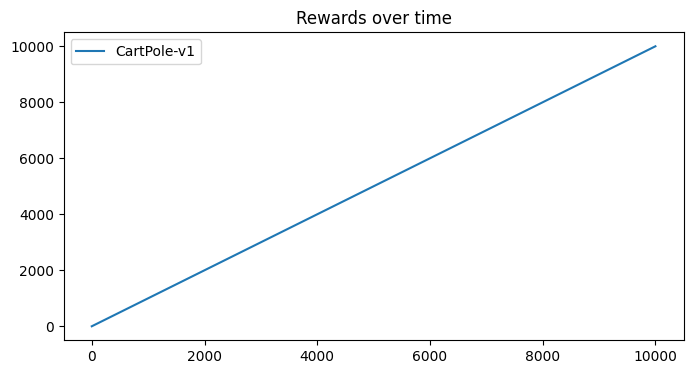

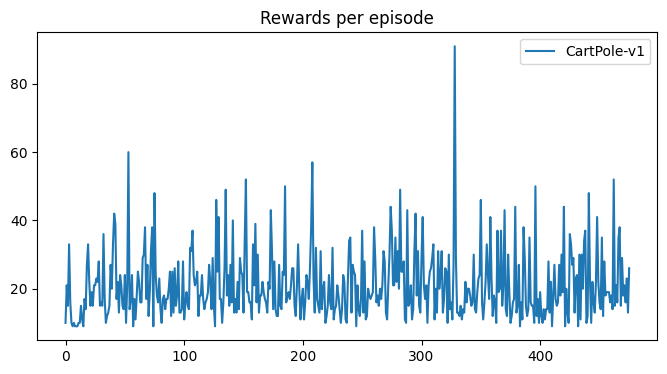

In [4]:
#fig, ax = plt.subplots(1,1, figsize=(20,12))

for env_name in results.keys():
    rewards_t, episodes_reward = results[env_name]
    plt.figure(figsize=(8,4))
    plt.plot(rewards_t, label=env_name)
    plt.legend()
    plt.title("Rewards over time")
    plt.show()
    plt.figure(figsize=(8,4))
    plt.plot(episodes_reward,label=env_name)
    plt.title("Rewards per episode")
    plt.legend()
    plt.show()
    